In [1]:
from sklearn.cluster import DBSCAN
from __future__ import division
import numpy as np
from hmmlearn import hmm
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator

## 3 start probabilities for HMMs 

In [2]:
start_probability_1 = np.array([0.33, 0.33, 0.34])
start_probability_2 = np.array([0.33, 0.33, 0.34])
start_probability_3 = np.array([0.33, 0.33, 0.34])

## 3 Transition probabilities for HMMs 

In [3]:
transition_probability_1 = np.array([
  [0.6, 0.2, 0.2],
  [0.2, 0.6, 0.2],
  [0.2, 0.2, 0.6]
])

transition_probability_2 = np.array([
  [0.2, 0.2, 0.6],
  [0.2, 0.6, 0.2],
  [0.6, 0.2, 0.2]
])

transition_probability_3 = np.array([
  [0.2, 0.6, 0.2],
  [0.2, 0.6, 0.2],
  [0.2, 0.6, 0.2]
])

## 3 Multinomial Emmision probabilities with 3 symbols to emmit:

In [4]:
emission_probability_1 = np.array([
  [0.8, 0.1, 0.1],
  [0.1, 0.8, 0.1],
  [0.1, 0.1, 0.8]
])

emission_probability_2 = np.array([
  [0.8, 0.1, 0.1],
  [0.1, 0.8, 0.1],
  [0.1, 0.1, 0.8]
])

emission_probability_3 = np.array([
  [0.1, 0.2, 0.7],
  [0.1, 0.2, 0.7],
  [0.1, 0.2, 0.7]
])

## Compile the HMM models:

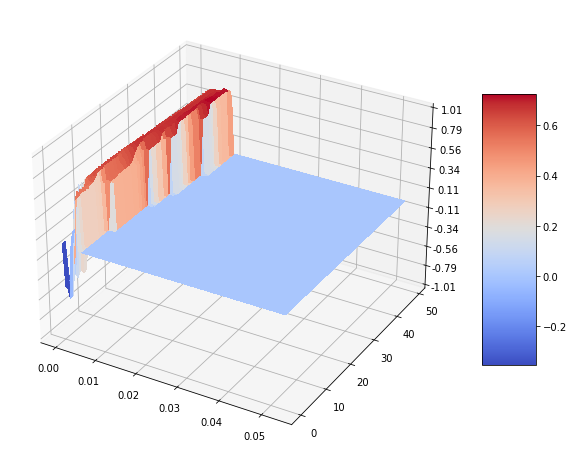

In [5]:
model_1 = hmm.MultinomialHMM(n_components=3)
model_1.startprob_=start_probability_1
model_1.transmat_=transition_probability_1
model_1.emissionprob_=emission_probability_1

model_2 = hmm.MultinomialHMM(n_components=3)
model_2.startprob_=start_probability_2
model_2.transmat_=transition_probability_2
model_2.emissionprob_=emission_probability_2

model_3 = hmm.MultinomialHMM(n_components=3)
model_3.startprob_=start_probability_3
model_3.transmat_=transition_probability_3
model_3.emissionprob_=emission_probability_3


hmm_seqs = [] # Save generated sequences  
hmm_seq = [] # Save generated sequences in different format 
hmm_labels = [] # Save the labels from which the sequences were generated 

for i in range(100):

    m1 = model_1.sample(100)[0] # 0th element for the emmisions of the generated sequences
    m2 = model_2.sample(100)[0]
    m3 = model_3.sample(100)[0]

    hmm_seqs.extend(m1) 
    hmm_seq.append(np.hstack(m1))
    hmm_labels.append(0)

    hmm_seqs.extend(m2)
    hmm_seq.append(np.hstack(m2))
    hmm_labels.append(1)
    
    hmm_seqs.extend(m3)
    hmm_seq.append(np.hstack(m3))
    hmm_labels.append(2)

lens = list(np.repeat(100, len(hmm_labels)))

elems = 3 # Number of unique elements from the emission matrix
hidden_states = 9 # Total number of hidden states

large_HMM = hmm.MultinomialHMM(n_components=hidden_states,n_iter=100,tol=0.01)
large_HMM.fit(hmm_seqs,lens)

from pomegranate import HiddenMarkovModel,DiscreteDistribution

emiss = []
for emis_matrices in range(hidden_states):
    qw = large_HMM.emissionprob_[emis_matrices,:].tolist()
    s = DiscreteDistribution({ j : qw[j] for j in range(elems)})
    emiss.append(s)

model = HiddenMarkovModel.from_matrix(large_HMM.transmat_, emiss, large_HMM.startprob_)
model.bake()

def tot_bha_dist(seq1,seq2):
    
    tr1 = model.forward_backward(seq1)[0][0:6,0:6]
    tr2 = model.forward_backward(seq2)[0][0:6,0:6]
    
    norm1 = tr1/tr1.sum(axis=1,keepdims=1)
    norm2 = tr2/tr2.sum(axis=1,keepdims=1)

    return -np.log(np.sqrt(norm1*norm2).sum()/len(norm1))

n = len(hmm_seq)
dists = np.zeros((n,n))
for i in range(n):
    for j in range(n):
        dists[i][j] = tot_bha_dist(hmm_seq[i],hmm_seq[j])
dists[dists < 0] = 0

from sklearn import metrics
eps_range = np.arange(0.0001,np.amax(dists)/3,0.0005) # Use the maximum values of the dists as upper limit of the eps values
min_samp_range = range(50) # Using half of the total number of sequences as an upper limit for the min samples range

sils = np.zeros((len(min_samp_range),len(eps_range)))
index = 0

labs = []

for epes in eps_range:
    for min_samp in min_samp_range:
        clustering = DBSCAN(eps=epes, min_samples=min_samp,metric='precomputed').fit(dists)
        if len(np.unique(clustering.labels_)) == 1 or len(np.unique(clustering.labels_)) == len(hmm_labels):
            sils[min_samp][index] = 0
        else:
            sils[min_samp][index] = metrics.silhouette_score(dists, clustering.labels_,metric='precomputed')
    index += 1
result = np.where(sils == np.amax(sils))
listOfCordinates = list(zip(result[0], result[1]))

epeses, samples = np.meshgrid(eps_range, min_samp_range)

fig, ax = plt.subplots(subplot_kw={"projection": "3d"},figsize=[10,10])
surf = ax.plot_surface(epeses, samples, sils,cmap=cm.coolwarm,
                       linewidth=0, antialiased=False)

# Customize the z axis.
ax.set_zlim(-1.01, 1.01)
ax.zaxis.set_major_locator(LinearLocator(10))
# A StrMethodFormatter is used automatically
ax.zaxis.set_major_formatter('{x:.02f}')

# Add a color bar which maps values to colors.
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

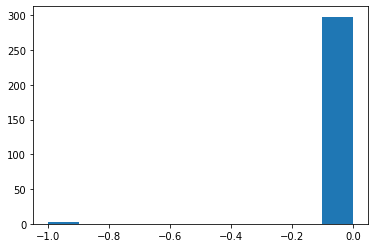

In [6]:
samp_max = min_samp_range[listOfCordinates[0][0]]
eps_max = eps_range[listOfCordinates[0][1]]
clustering = DBSCAN(eps=eps_max, min_samples=samp_max,metric='precomputed').fit(dists)

plt.hist(clustering.labels_)
plt.show()

In [7]:
print("Homogeneity: %0.3f" % metrics.homogeneity_score(hmm_labels, clustering.labels_))
print("Completeness: %0.3f" % metrics.completeness_score(hmm_labels, clustering.labels_))
print("V-measure: %0.3f" % metrics.v_measure_score(hmm_labels, clustering.labels_))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(hmm_labels, clustering.labels_))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(hmm_labels, clustering.labels_))

Homogeneity: 0.002
Completeness: 0.068
V-measure: 0.005
Adjusted Rand Index: -0.000
Adjusted Mutual Information: -0.003


In [8]:
print(hmm_seq[0])
print(hmm_seq[3])
print(hmm_seq[6])

[2 1 0 0 0 0 0 0 0 2 0 2 2 1 0 2 2 0 2 2 0 0 1 1 0 0 2 1 0 1 0 0 2 2 1 0 1
 0 0 1 1 1 1 1 0 1 1 0 1 0 0 0 0 1 0 0 2 2 0 2 2 2 0 2 2 2 2 2 2 2 1 2 2 2
 0 0 0 0 0 2 1 1 1 1 0 2 0 2 2 0 2 0 2 0 1 2 2 2 0 2]
[1 2 2 2 1 1 1 1 1 0 0 2 0 0 2 1 1 2 0 2 0 2 0 2 0 1 0 1 1 1 1 1 2 0 0 0 0
 2 2 0 1 1 0 0 0 0 1 1 2 1 1 1 1 1 2 2 1 1 2 2 0 0 0 0 0 1 1 2 1 1 1 1 0 2
 1 1 1 2 2 1 1 2 0 2 2 2 1 1 0 0 1 2 1 0 1 1 1 0 2 2]
[2 1 0 0 0 2 2 1 0 1 1 0 0 1 1 1 2 1 1 2 2 2 2 0 0 0 0 0 0 1 0 0 2 2 2 2 2
 0 0 1 0 0 1 1 0 2 0 1 0 1 0 1 1 1 1 1 2 0 0 0 0 2 1 1 1 0 0 2 0 1 1 1 1 1
 0 0 0 0 0 0 0 0 0 0 2 2 2 2 0 2 2 1 0 1 0 0 1 0 1 1]


In [9]:
print(hmm_seq[1])
print(hmm_seq[4])
print(hmm_seq[7])

[1 1 1 0 1 0 1 2 0 1 2 0 2 1 2 1 1 2 0 1 0 2 0 0 2 1 2 2 1 0 0 1 1 1 0 2 2
 1 0 1 0 0 0 1 0 2 1 1 2 0 0 2 0 2 2 1 1 1 1 0 2 1 2 0 2 1 0 1 2 0 2 0 2 0
 2 0 0 1 1 1 1 1 1 2 1 2 2 2 1 0 0 2 2 0 2 0 0 2 1 2]
[0 1 0 1 1 1 1 2 1 1 1 0 0 1 2 2 0 2 0 2 0 2 0 0 2 2 1 1 1 2 1 1 1 1 0 0 1
 2 0 2 2 1 0 2 2 1 1 1 1 0 0 2 2 0 1 0 2 2 1 1 1 0 2 1 0 2 1 0 2 0 0 0 0 1
 1 0 2 0 2 0 1 0 2 2 0 2 1 1 0 1 1 0 0 1 0 1 0 2 1 2]
[2 0 2 2 1 0 1 1 2 0 2 0 2 2 2 2 0 1 0 2 0 2 0 2 2 0 1 0 1 2 0 0 1 0 2 1 0
 1 1 0 1 0 0 2 1 2 1 0 0 2 2 2 0 2 0 0 2 2 2 1 0 0 2 0 1 0 2 0 2 0 2 0 2 0
 0 2 0 1 1 2 1 1 2 2 0 1 0 2 0 2 1 2 2 0 0 2 0 1 2 2]


In [10]:
print(hmm_seq[2])
print(hmm_seq[5])
print(hmm_seq[8])

[2 2 2 2 1 0 1 2 2 1 2 2 2 2 2 1 1 2 2 1 2 2 2 1 2 0 1 2 2 0 1 0 2 2 2 2 2
 1 1 2 2 2 2 2 0 2 2 1 2 1 2 0 2 0 2 2 1 2 2 1 0 1 2 2 1 1 2 2 0 1 2 1 2 2
 1 2 2 0 0 2 2 2 1 2 1 2 1 2 2 2 0 2 2 1 2 2 1 2 2 1]
[2 2 1 2 2 2 1 2 2 1 2 1 2 2 2 2 0 1 2 2 2 2 2 2 0 2 0 2 2 2 2 1 1 2 2 2 2
 0 1 2 2 0 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 1 2 2 2 0 1 2 2 2 2 2 2 2 2 1 1
 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 0 2 1 2 2 2 2 2 2 2]
[2 2 2 2 2 1 2 2 2 1 1 2 2 0 2 2 1 2 1 2 1 2 2 2 0 0 1 0 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 0 1 1 2 2 2 2 0 1 2 0 2 1 2 1 0 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 0
 2 2 0 0 2 1 2 2 0 0 2 2 2 1 2 2 1 0 2 1 1 2 2 0 1 2]
